# MDSC-302(P) Deep Learning Practicals Final

# Name : Guru Prasanth R S
# Regd No : 240402008003

In [2]:
# Imports and NamedTuples
import os
import glob
import csv
import copy
import functools
import collections
import numpy as np
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset

# Tuples for coordinates
IrcTuple = collections.namedtuple('IrcTuple', ['index', 'row', 'col'])
XyzTuple = collections.namedtuple('XyzTuple', ['x', 'y', 'z'])
#explanation;-This section imports all necessary libraries and defines simple namedtuples for handling coordinate data. IrcTuple is for voxel indices, and XyzTuple is for real-world (mm) coordinates.

In [3]:
# Coordinate Conversion Function
def xyz2irc(coord_xyz, origin_xyz, vxSize_xyz, direction_a):
    """
    Convert patient coordinates (mm) to voxel indices (IRC)
    """
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coord_a = np.array(coord_xyz)

    # Apply inverse transform to voxel space
    cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
    cri_a = np.round(cri_a)
    return IrcTuple(int(cri_a[2]), int(cri_a[1]), int(cri_a[0]))
#Explanation;-This function converts a coordinate in millimeters (patient space) to voxel indices in the CT array. It accounts for voxel spacing and the scan’s orientation.

In [4]:
# CT Loader Class
class Ct:
    def __init__(self, series_uid, base_path='/kaggle/input/subset0-luna-dataset/subset0'):
        # Locate .mhd file
        mhd_files = glob.glob(f'{base_path}/{series_uid}.mhd')
        if not mhd_files:
            raise FileNotFoundError(f"No .mhd file found for {series_uid}")
        mhd_path = mhd_files[0]

        # Load CT
        ct_mhd = sitk.ReadImage(mhd_path)
        ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
        ct_a.clip(-1000, 1000, ct_a)

        # Store metadata
        self.series_uid = series_uid
        self.hu_a = ct_a
        self.origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
        self.vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
        self.direction_a = np.array(ct_mhd.GetDirection()).reshape(3,3)

    def getRawCandidate(self, center_xyz, width_irc):
        # Convert center to voxel indices
        center_irc = xyz2irc(center_xyz, self.origin_xyz, self.vxSize_xyz, self.direction_a)

        # Extract cubic chunk
        slice_list = []
        for axis, center_val in enumerate(center_irc):
            start_ndx = int(round(center_val - width_irc[axis]/2))
            end_ndx = int(start_ndx + width_irc[axis])
            slice_list.append(slice(start_ndx, end_ndx))
        ct_chunk = self.hu_a[tuple(slice_list)]
        return ct_chunk, center_irc
#Exaplnation;-Ct loads a CT scan from a .mhd file, clips HU values to [-1000, 1000], and stores metadata for voxel conversions. getRawCandidate extracts a cubic patch around a nodule in voxel coordinates.

In [5]:
# Caching functions
@functools.lru_cache(maxsize=1, typed=True)
def getCt(series_uid):
    return Ct(series_uid)

@functools.lru_cache(maxsize=128, typed=True)
def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    return ct.getRawCandidate(center_xyz, width_irc)
#Explanation;-These cached functions avoid reloading CT scans multiple times. getCt caches a single CT in memory; getCtRawCandidate caches multiple nodule chunks for efficiency.

In [6]:
# Candidate Info Parsing
CandidateInfoTuple = collections.namedtuple('CandidateInfoTuple', 'isNodule_bool, diameter_mm, series_uid, center_xyz')

@functools.lru_cache(1)
def getCandidateInfoList(requireOnDisk_bool=True):
    """
    Parses LUNA16 annotations and candidates CSVs, returns a unified list.
    """
    # Detect available .mhd files
    mhd_list = glob.glob('/kaggle/input/**/*subset*/**/*.mhd', recursive=True)
    presentOnDisk_set = {os.path.splitext(os.path.basename(p))[0] for p in mhd_list}

    # Load CSVs (replace paths if needed)
    annotations_path = '/kaggle/input/luna-subset-csv/luna/annotations.csv'
    candidates_path = '/kaggle/input/luna-subset-csv/luna/candidates.csv'

    # Parse true nodules
    diameter_dict = {}
    with open(annotations_path) as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            series_uid = row[0]
            center_xyz = tuple(float(x) for x in row[1:4])
            diameter_mm = float(row[4])
            diameter_dict.setdefault(series_uid, []).append((center_xyz, diameter_mm))

    # Parse candidate entries
    candidateInfo_list = []
    with open(candidates_path) as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            series_uid = row[0]
            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue
            isNodule_bool = bool(int(row[4]))
            candidate_xyz = tuple(float(x) for x in row[1:4])
            diameter_mm = 0.0
            for ann_xyz, ann_d in diameter_dict.get(series_uid, []):
                if all(abs(candidate_xyz[i]-ann_xyz[i]) <= ann_d/4 for i in range(3)):
                    diameter_mm = ann_d
                    break
            candidateInfo_list.append(CandidateInfoTuple(isNodule_bool, diameter_mm, series_uid, candidate_xyz))

    print(f"Loaded {len(candidateInfo_list)} candidates")
    return candidateInfo_list
#Exaplanation:-
#This function reads both annotations.csv and candidates.csv, checks which CT scans exist on disk, and merges nodule annotations with candidates into a unified list of CandidateInfoTuple.

In [7]:
# LunaDataset for PyTorch
class LunaDataset(Dataset):
    def __init__(self, val_stride=0, isValSet_bool=None, series_uid=None):
        self.candidateInfo_list = copy.copy(getCandidateInfoList())

        # Filter by series UID if specified
        if series_uid:
            self.candidateInfo_list = [x for x in self.candidateInfo_list if x.series_uid == series_uid]

        # Validation split
        if isValSet_bool:
            assert val_stride > 0
            self.candidateInfo_list = self.candidateInfo_list[::val_stride]
        elif val_stride > 0:
            del self.candidateInfo_list[::val_stride]

    def __len__(self):
        return len(self.candidateInfo_list)

    def __getitem__(self, ndx):
        candidate = self.candidateInfo_list[ndx]
        width_irc = (32, 48, 48)
        candidate_a, center_irc = getCtRawCandidate(candidate.series_uid, candidate.center_xyz, width_irc)

        # Convert to tensor and add channel dimension
        candidate_t = torch.from_numpy(candidate_a).to(torch.float32).unsqueeze(0)
        pos_t = torch.tensor([not candidate.isNodule_bool, candidate.isNodule_bool], dtype=torch.long)
        return candidate_t, pos_t, candidate.series_uid, torch.tensor([center_irc.index, center_irc.row, center_irc.col])


In [8]:
# Example Usage / Testing
if __name__ == "__main__":
    dataset = LunaDataset()
    print("Dataset length:", len(dataset))

    sample = dataset[0]
    print("Candidate tensor shape:", sample[0].shape)
    print("Classification tensor:", sample[1])
    print("Series UID:", sample[2])
    print("Center voxel indices:", sample[3])


Loaded 56938 candidates
Dataset length: 56938
Candidate tensor shape: torch.Size([1, 32, 48, 48])
Classification tensor: tensor([1, 0])
Series UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260
Center voxel indices: tensor([ 23, 316, 430])


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Dataset
class LunaDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Only return data and labels (remove None)
        return self.data[idx], self.labels[idx]

# Model
class LunaModel(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=32, output_dim=2):
        super(LunaModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training Application
METRICS_SIZE = 2  # For example: loss and accuracy

class LunaTrainingApp:
    def __init__(self, model, train_dl, val_dl, lr=0.001, device=None):
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()

    # Single batch loss computation
    def computeBatchLoss(self, batch_ndx, batch_tup):
        inputs, targets = batch_tup
        inputs = inputs.to(self.device).float()
        targets = targets.to(self.device).long()
        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        _, preds = torch.max(outputs, 1)
        acc = (preds == targets).float().mean()
        return loss, acc

    # Training one epoch
    def doTraining(self, epoch_ndx):
        self.model.train()
        running_loss = 0.0
        running_acc = 0.0
        for batch_ndx, batch_tup in enumerate(self.train_dl):
            self.optimizer.zero_grad()
            loss, acc = self.computeBatchLoss(batch_ndx, batch_tup)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item() * batch_tup[0].size(0)
            running_acc += acc.item() * batch_tup[0].size(0)

        avg_loss = running_loss / len(self.train_dl.dataset)
        avg_acc = running_acc / len(self.train_dl.dataset)
        return avg_loss, avg_acc

    # Validation one epoch
    def doValidation(self, epoch_ndx):
        self.model.eval()
        running_loss = 0.0
        running_acc = 0.0
        with torch.no_grad():
            for batch_ndx, batch_tup in enumerate(self.val_dl):
                loss, acc = self.computeBatchLoss(batch_ndx, batch_tup)
                running_loss += loss.item() * batch_tup[0].size(0)
                running_acc += acc.item() * batch_tup[0].size(0)

        avg_loss = running_loss / len(self.val_dl.dataset)
        avg_acc = running_acc / len(self.val_dl.dataset)
        return avg_loss, avg_acc

    # Logging metrics
    def logMetrics(self, epoch, phase, metrics):
        loss, acc = metrics
        print(f"Epoch {epoch} | {phase} -> Loss: {loss:.4f}, Acc: {acc:.4f}")

    # Run full training
    def run(self, epochs=5):
        for epoch in range(1, epochs + 1):
            trnMetrics = self.doTraining(epoch)
            self.logMetrics(epoch, 'train', trnMetrics)
            valMetrics = self.doValidation(epoch)
            self.logMetrics(epoch, 'val', valMetrics)

# Dummy data for testing
import numpy as np

# Let's assume 10 features, 2 classes, 100 samples for train, 20 for val
X_train = torch.tensor(np.random.rand(100, 10), dtype=torch.float32)
y_train = torch.tensor(np.random.randint(0, 2, 100), dtype=torch.long)
X_val = torch.tensor(np.random.rand(20, 10), dtype=torch.float32)
y_val = torch.tensor(np.random.randint(0, 2, 20), dtype=torch.long)

train_ds = LunaDataset(X_train, y_train)
val_ds = LunaDataset(X_val, y_val)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16)

# Run training
model = LunaModel(input_dim=10, hidden_dim=32, output_dim=2)
trainer = LunaTrainingApp(model, train_dl, val_dl)
trainer.run(epochs=3)

Epoch 1 | train -> Loss: 0.7013, Acc: 0.4100
Epoch 1 | val -> Loss: 0.6824, Acc: 0.6000
Epoch 2 | train -> Loss: 0.6949, Acc: 0.5000
Epoch 2 | val -> Loss: 0.6913, Acc: 0.6000
Epoch 3 | train -> Loss: 0.6894, Acc: 0.5800
Epoch 3 | val -> Loss: 0.7005, Acc: 0.4000


In [15]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Paths and Data Setup
base_dir = ""
subset_dir = os.path.join(base_dir, "/kaggle/input/subset0-luna-dataset/subset0")
annotations_path = os.path.join(base_dir, "/kaggle/input/luna-subset-csv/luna/annotations_with_malignancy.csv")

# Load annotations
annotations = pd.read_csv(annotations_path)
print("Annotations loaded:", annotations.shape)

# Custom Dataset for LUNA
class LUNADataset(Dataset):
    def __init__(self, subset_dir, annotations, transform=None):
        self.subset_dir = subset_dir
        self.annotations = annotations
        self.transform = transform
        self.files = [f for f in os.listdir(subset_dir) if f.endswith(".mhd")]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx]
        file_path = os.path.join(self.subset_dir, file_name)

        # Read image volume
        image = sitk.ReadImage(file_path)
        image_array = sitk.GetArrayFromImage(image).astype(np.float32)

        # Take the middle slice for simplicity
        slice_idx = image_array.shape[0] // 2
        image_slice = image_array[slice_idx]
        image_slice = np.expand_dims(image_slice, axis=0)  # [1, H, W]

        # Assign label (for demo, random 0/1 if malignancy missing)
        row = self.annotations[self.annotations["seriesuid"].str.contains(file_name.split(".")[0])]
        if not row.empty and "malignancy" in row.columns:
            label = int(row["malignancy"].values[0] > 3)
        else:
            label = np.random.randint(0, 2)

        # Normalize and convert to tensor
        image_tensor = torch.tensor(image_slice)
        image_tensor = (image_tensor - image_tensor.min()) / (image_tensor.max() - image_tensor.min())

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label

# Transforms and Dataset Split
transform = transforms.Compose([
    transforms.Resize((128, 128)),
])

dataset = LUNADataset(subset_dir, annotations, transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

# Define CNN Model
class LUNACNN(nn.Module):
    def __init__(self):
        super(LUNACNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = LUNACNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print("\n=== Model Evaluation ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Using device: cpu
Annotations loaded: (1182, 14)
Epoch [1/5] Train Loss: 1.1542 | Val Loss: 0.7326
Epoch [2/5] Train Loss: 0.6932 | Val Loss: 0.6947
Epoch [3/5] Train Loss: 0.6916 | Val Loss: 0.7027
Epoch [4/5] Train Loss: 0.6933 | Val Loss: 0.6916
Epoch [5/5] Train Loss: 0.6938 | Val Loss: 0.6991

=== Model Evaluation ===
Accuracy: 0.6429
Precision: 0.4133
Recall: 0.6429
F1 Score: 0.5031


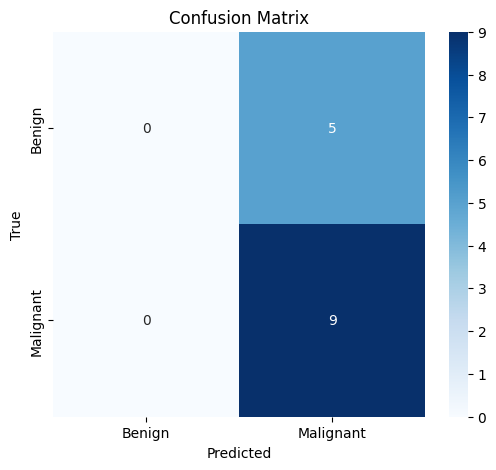

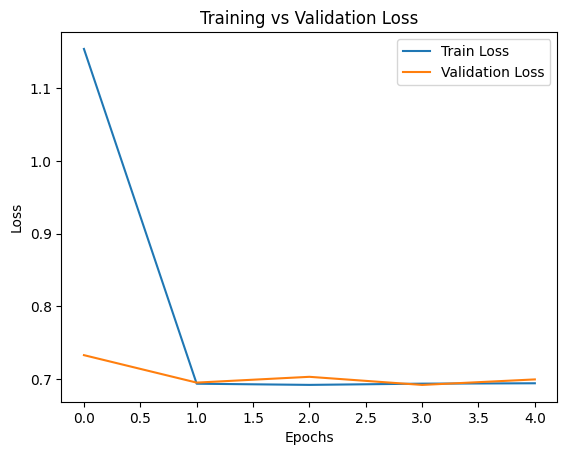

In [16]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot Loss Curves
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.show()